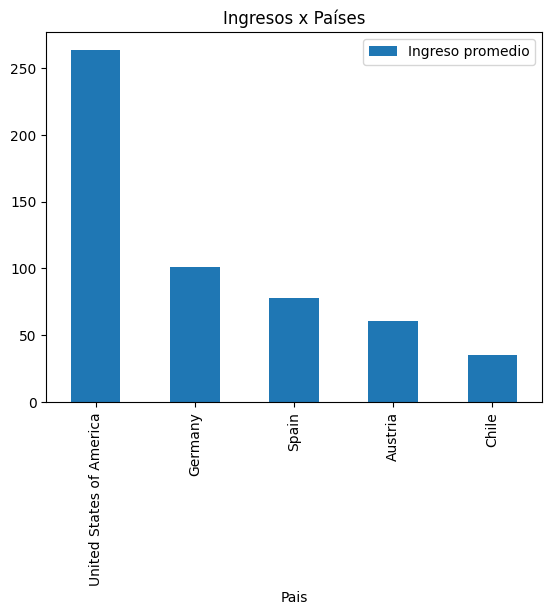

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def cargar_dataset(ruta_dataset: str):
    df = pd.read_csv(ruta_dataset,encoding="latin-1",sep=",")
    # print(df.head(5))
    return df

# eliminar aquellas columnas que posean un porcentaje mayor a cantidad_null% de celdas nulas y luego reemplazar
# las celdas nulas restantes con el str 'Sin informaci´on'. Finalmente, debes retornar el dataframe limpio.
def limpiar_dataset(dataframe, cantidad_null: int):
    ValoresSinDatos = {}
    PorcentajeSinDatos = {}
    Columna = list(dataframe.columns.values)
    TotalFilas = dataframe.shape[0]

    dataframe = dataframe.fillna("Sin información")
    
    for col in range(len(Columna)):
        # print(Columna[col])  #eliminar este print en promt, es sólo para validar si esta leyendo las columnas..
        contador = 0
        for index in range(TotalFilas):
            if dataframe.loc[index][Columna[col]]  == "Sin información":
                contador += 1
        ValoresSinDatos[Columna[col]] = contador
    
    for k,v in ValoresSinDatos.items():
          porcentaje = v / TotalFilas * 100
          PorcentajeSinDatos[k] = porcentaje
          
    for k,v in PorcentajeSinDatos.items():
        if PorcentajeSinDatos[k] > cantidad_null:
            print(f"Se eliminará la columna {k} por tener {v} valores nulos") #eliminar este promt de pantalla al eliminar columnas
            del dataframe[k]
    return dataframe   

def calcular_ingresos_por_pais(dataframe):
    Paises = ["Germany", "Spain", "Chile", "Austria", "United States of America"]
    DataPromedio = []
    
    for i in range(len(Paises)):
        df_pais = dataframe.loc[dataframe['Country'] == Paises[i]]
        # print(Paises[i], df_pais, df_pais.shape)
        contador = 0
        suma = 0
        # lo tengo que pasar por todo el dataframe, pq no debo considerar los sin información para el promedio
        for index in range(df_pais.shape[0]):
            if df_pais.iloc[index]['ConvertedCompYearly']  != "Sin información":
                contador += 1
                suma += float(df_pais.iloc[index]['ConvertedCompYearly'])
        
        if contador != 0: promedio = suma / contador

        DataPromedio.append([Paises[i] , promedio])  # el promedio por país está dentro de una lista de tuplas
            
    Data_ordenada = sorted(DataPromedio, key=lambda x: x[1], reverse=True) # Retorna una lista ordenada desde el key promedio de la tupla
    #Luego de ordenar la lista, lo formateo a miles "."      
    for i in range(len(Data_ordenada)):
        Data_ordenada[i][1] = '{:,.0f}'.format(Data_ordenada[i][1]).replace(',','.')
    #transpaso la lista ordenada de tuplas a un data frame con las columnas seleccionadas
    df_ordenado_paises = pd.DataFrame(Data_ordenada, columns=["Pais", "Ingreso promedio"])
    
    return df_ordenado_paises

def calcular_ingresos_por_experiencia(dataframe):
    # realizo un dataframe con tres columnas, que son las que me interesan
    df = dataframe.loc[:, ["YearsCode","YearsCodePro", "ConvertedCompYearly"]]   
    # esta es una lista con los datos inválidos dentros del los años de experiencias como junior y senior 
    datos_invalidos = ["Sin información", "Less than 1 year", "More than 50 years"]
    # lista del nombre de las columnas: ["YearsCode","YearsCodePro", "ConvertedCompYearly"]
    nombres_columnas = df.columns.values

    #limpio datos invalidos, pq si en el salario anual no tengo información, no puedo sacar ninguna estadística con respecto a este monto
    df.drop(df[df["ConvertedCompYearly"]=="Sin información"].index, inplace=True)
    #cuando son menores que 1 año y mayores que 50 años, le atribuyo un valor, 0 y 51 respectivamente, porque necesito que sean valores float. 
    for col in range(len(nombres_columnas)-1):
        for datos in datos_invalidos:
            if datos != datos_invalidos[2]:
                df[nombres_columnas[col]] = np.where(df[nombres_columnas[col]]==datos, "0", df[nombres_columnas[col]])
            else:
                df[nombres_columnas[col]] = np.where(df[nombres_columnas[col]]==datos, "51", df[nombres_columnas[col]])
    
    # una vez limpiado y estandarizado los datos numericos, lo puedo pasar a float
    for col in range(len(nombres_columnas)):
        df[nombres_columnas[col]] = df[nombres_columnas[col]].astype('float64')
    
    # creo una nueva columan con los Total Años que es la suma de los años de junior mas senior(pro)
    df["Total Años"] = df["YearsCode"] + df["YearsCodePro"]
    # elimino el total años sumados mayores a 55 años, pq creo que son cotas superiores invalidas ...
    df.drop(df[df["Total Años"]>55].index, inplace=True)
    
    #realizo una nueva columna con la función cut() ver pandas.pydata.org, especialmente usada para determinar rango de años, ver doc.
    df["Rango Edad"] = pd.cut(df["Total Años"], bins=range(0, 60, 5), right=False)
    #formateo el obtejo category que me entrego, con una función anómima para el intervalo 
    df["Años de experiencia"] = df["Rango Edad"].apply(lambda x: f"{int(x.left)} - {int(x.right)}")
    
    # lo paso a groupby pq sale un Warning, y con esto lo saco .. lo informé x correo, también me sale otro Warning para poner el observed=False
    df2 = df.groupby("Años de experiencia", observed=False).agg({"ConvertedCompYearly":["min","max"]})
    # Ahora con la tabla correcta, puedo hacer una tabla dinámica con los años de experiencia y montos de los sueldos, para obtener por grupos de intervalos el max y min
    #df2 = df.pivot_table(index="Años de experiencia", values="ConvertedCompYearly", observed=False, aggfunc={np.min,np.max})

    #Asingo el nombre de las columnas
    df2.columns = ["Intervalo inferior (USD/Año)","Intervalo superior (USD/Año)" ]

    #FORMATEAR A MILES: usé la función map() que es como un for dentro del df, y la función anómima lambda, para realizar un replace()
    df2["Intervalo inferior (USD/Año)"] = df2["Intervalo inferior (USD/Año)"].map("{:,.0f}".format).apply(lambda x:x.replace(",","."))
    df2["Intervalo superior (USD/Año)"] = df2["Intervalo superior (USD/Año)"].map("{:,.0f}".format).apply(lambda x:x.replace(",","."))

    # reintegro el índice, para que los Años de experiencia sean la primera columna. 
    df2.reset_index(inplace=True)

    return df2


def calcular_empleabilidad(dataframe):
    # Deberás encontrar el porcentaje de empleabilidad basado en la raza y el género de los desarrolladores. 
    # columnas a usar Employment, Gender, Ethnicity
    raza = ["Black or of African descent","Hispanic or Latino/a/x","East Asian","I don't know","Indigenous (such as Native American, Pacific Islander, or Indigenous Australian)","Middle Eastern","White or of European descent"]
    genero =  ['Man','Non-binary','genderqueer','gender non-conforming','Woman']

    df_i = dataframe.loc[:, ["Ethnicity","Gender", "Employment"]]

    # Filtro mis valores según la lista de raza y género entregada, para construir mi df a trabajar, tuve que realizarlo dentro de un dataframe sino me sale un Warning de copia
    df = pd.DataFrame(df_i[(df_i["Ethnicity"].isin(raza)) & (df_i["Gender"].isin(genero))])

    # Consulto por los valores únicos de la columna Employment y lo dejo en una lista
    # Valores_unicos_Employment = dataframe["Employment"].unique().tolist()
    # print(Valores_unicos_Employment)
    
    # le asigno un peso a cada opción de empleabilidad, si es full-time es 1, para sumar, .. trate de usar contar, y no me dejo? el ny.count
    df.loc[df["Employment"]=="Employed full-time", "Employment"] = 1
    df.loc[df["Employment"]=="Employed part-time", "Employment"] = 0.5
    df.loc[df["Employment"]=="Not employed, but looking for work", "Employment"] = 0
    
    # Agrupo por Ethnicity y Gender y cuento las ocurrencias del Employment según su peso mensionado arriba, use groupby, me da el mismo resultado con el otro indicado abajo
    df_EM = df.groupby(["Ethnicity", "Gender"]).agg({"Employment":"sum"})
    
    # realizo una tabla dinámica con col: raza y genero y los valores de Empleabilidad para que se sumen , 
    # ----- esto que está comentado, es una forma alternativa, pero me da un warning ---- dice que ahora ocupe el DataFrameGroupBy.sum
    #df_EM = df.pivot_table(index=["Ethnicity", "Gender"],values="Employment", aggfunc=np.sum)
     
    # ahora calculo el porcentaje pero a la suma de filas en total del df_i, pq quiero su comparación real al total de la muestra
    df_EM["Employment"] = df_EM["Employment"]/df_i.shape[0]*100
    
    #formateo a % 
    df_EM["Employment"] = df_EM["Employment"].map("{:.2f}%".format).apply(lambda x:x.replace(",","."))
    
    # pongos los index original, para dejarlo como título
    df_EM.reset_index(inplace=True)

    return df_EM

def graficar_ingresos_paises(dataframe):
    dataframe['Ingreso promedio'] = dataframe['Ingreso promedio'].astype('float64')
    dataframe.plot(kind="bar", x="Pais", y="Ingreso promedio", title="Ingresos x Países")
    plt.show()

if __name__ == "__main__":
    df = cargar_dataset("developers_info.csv")
    df_limpios = limpiar_dataset(df,50)
    df_p = calcular_ingresos_por_pais(df_limpios)
    df_i = calcular_ingresos_por_experiencia(df_limpios)
    df_e = calcular_empleabilidad(df_limpios)
    graficar_ingresos_paises(df_p)
    # print(df_p.dtypes) 


In [149]:
df_p


,Pais,Ingreso promedio
0,United States of America,263.279
1,Germany,100.835
2,Spain,77.489
3,Austria,60.995
4,Chile,35.356


In [150]:
df_i

,Años de experiencia,Intervalo inferior (USD/Año),Intervalo superior (USD/Año)
0,0 - 5,21,4.000.000
1,5 - 10,2,14.411.628
2,10 - 15,2,30.468.516
3,15 - 20,12,10.500.000
4,20 - 25,3,20.000.000
5,25 - 30,12,11.000.000
6,30 - 35,6,10.000.000
7,35 - 40,1,12.500.000
8,40 - 45,5,10.000.000
9,45 - 50,93,17.500.000


In [151]:
df_e

,Ethnicity,Gender,Employment
0,Black or of African descent,Man,1.85%
1,Black or of African descent,Non-binary,0.01%
2,Black or of African descent,Woman,0.13%
3,East Asian,Man,3.03%
4,East Asian,Non-binary,0.04%
5,East Asian,Woman,0.26%
6,Hispanic or Latino/a/x,Man,5.07%
7,Hispanic or Latino/a/x,Non-binary,0.05%
8,Hispanic or Latino/a/x,Woman,0.26%
9,I don't know,Man,1.96%
